# 5. 训练过程 Training process

# 目录
- [ 6.1 - 前言：需要几行代码就可以在GPU训练lamini](#6.1)
- [ 6.2 - EleutherAI/pythia模型介绍](#6.2)
- [ 6.3 - 微调实验准备](#6.3)
  - [6.3.1 - 实验环境准备](#6.3.1)
  - [6.3.2 - 导入 lamini 训练数据](#6.3.2)
  - [6.3.3 - 设置模型、配置参数、分词器](#6.3.3)
  - [6.3.4 - 加载基础模型](#6.3.4)
  - [6.3.5 - 定义推理函数](#6.3.5)
  - [6.3.6 - 使用基础模型](#6.3.6)
  - [6.3.7 - 训练参数配置](#6.3.7)
- [ 6.4 - 微调训练](#6.4)
  - [6.4.1 - 开始训练](#6.4.1)
  - [6.4.2 - 本地存储模型](#6.4.2)
  - [6.4.3 - 运行微调过的模型](#6.4.3)
  - [6.4.4 - 训练运行在线模型](#6.4.4)
  - [6.4.5 - 用更大的模型探索效果](#6.4.5)
  - [6.4.6 - 用更小的模型探索效果](#6.4.6)
  - [6.4.7 - 使用三行代码微调lamini](#6.4.7)
- [ 6.5 - 附表](#6.5)
  - [6.5.1 - 笔者训练的效果](#6.5.1)

<a name='6.1'></a>
## 6.1 前言：需要几行代码就可以在GPU训练lamini
llama库文档地址：https://lamini-ai.github.io/ 

从使用角度讲只需要下面几行代码就可以完成模型的微调，但是要理解这个过程请完成后续的试验。

```
from llama import BasicModelRunner
# 从基础模块导入模型
model = BasicModelRunner("EleutherAI/pythia-410m")
# 导入训练数据
model.load_data_from_jsonlines("lamini_docs.jsonl")
model.train()
```

<a name='6.2'></a>
## 6.2 EleutherAI/pythia模型介绍
Pythia缩放套件是一个模型集合，用于促进可解释性研究(见论文) https://arxiv.org/pdf/2304.01373.pdf 。包含70M、160M、410M、1B、1.4B、2.8B、6.9B、12B两套共8个型号。对于每个大小，有两个模型:一个在Pile上训练，另一个在数据集进行全局重复数据删除后在Pile上训练。所有8种模型大小都是在完全相同的数据上以完全相同的顺序进行训练的。我们还为每个模型提供154个中间检查点，作为分支托管在hug Face上。Pythia模型套件旨在促进大型语言模型的科学研究，特别是可解释性研究。尽管没有将下游性能作为设计目标，但我们发现这些模型的性能达到或超过了类似和相同尺寸的模型，例如OPT和GPT-Neo套件中的模型。关于以前的早期版本和命名约定的详细信息。之前，我们向公众发布了一个早期版本的Pythia套件。然而，我们决定重新训练模型套件来解决一些超参数差异。这个模型卡片列出了变化;进一步的讨论见Pythia论文的附录B。我们发现两个Pythia版本在基准测试性能上没有差异。旧的模型仍然可用，但我们建议重新训练套件，如果你刚刚开始使用Pythia。这是当前版本。请注意，Pythia套件中的所有模型都在2023年1月重新命名。为了清楚起见，在此模型卡中提供了一个比较新旧名称的表，以及确切的参数计数。



<a name='6.2'></a>
## 6.3 微调实验准备

<a name='6.3.1'></a>
### 6.3.1 实验环境准备

In [ ]:
# 安装环境  torch版本大家先试试本来的版本可不可行再安装
!pip install -r requirements.txt 

In [35]:
import datasets
import tempfile
import logging
import random
import config  # 这里的config是官方自带的  我们导入了
import os
import yaml
import logging
import time
import torch
import transformers

from utilities import * # 这里的utilities是官方自带的  我们导入了
from transformers import AutoTokenizer
from transformers import AutoModelForCausalLM
from transformers import TrainingArguments
from transformers import AutoModelForCausalLM
from llama import BasicModelRunner
from llama import BasicModelRunner

logger = logging.getLogger(__name__)
global_config = None

<a name='6.3.2'></a>
### 6.3.2 导入 lamini 训练数据

In [ ]:
dataset_name = "lamini_docs.jsonl"  # 这是导入微调的文件
dataset_path = f"/content/{dataset_name}"
use_hf = False

### lamini_docs.jsonl截取内容
可以看到是关于llama的一些问题。可以看到是对llama为主题的做的问答对，也即是llama微调的内容。
<br>那么对你来说这个内容可以是客服问题/或是和女仆的对话等等……
<br>
<br>送入数据结构：{
    "question":"问题",
    "answer":"回答"
}
<br>
<br>问答例子：<br>
{
    "question": "What are the different types of documents available in the repository (e.g., installation guide, API documentation, developer's guide)?", <br>
    "answer": "Lamini has documentation on Getting Started, Authentication, Question Answer Model, Python Library, Batching, Error Handling, Advanced topics, and class documentation on LLM Engine available at https://lamini-ai.github.io/."}

{"question": "What is the recommended way to set up and configure the code repository?", <br>"answer": "Lamini can be downloaded as a python package and used in any codebase that uses python. Additionally, we provide a language agnostic REST API. We\u2019ve seen users develop and train models in a notebook environment, and then switch over to a REST API to integrate with their production environment."}

{"question": "How can I find the specific documentation I need for a particular feature or function?", <br>"answer": "You can ask this model about documentation, which is trained on our publicly available docs and source code, or you can go to https://lamini-ai.github.io/."}

In [37]:
dataset_path = "lamini/lamini_docs"
use_hf = True

<a name='6.3.3'></a>
### 6.3.3 设置模型、配置参数、分词器

In [38]:
# 先选了比较小的70m
model_name = "EleutherAI/pythia-70m"

In [39]:
training_config = {
    "model": {
        "pretrained_name": model_name,
        "max_length" : 2048  # 最长输入
    },
    "datasets": {  # 数据设置
        "use_hf": use_hf,
        "path": dataset_path
    },
    "verbose": True
}

In [40]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
# tokenizer.eos token是分词器对象的属性，它表示分词器所使用的特殊标记(token)中的"end of sequence”(序列结束)标记。
# 这个特殊标记在处理自然语言文本时经常用于表示句子或文本的结尾。
# 在这段代码中，它被赋值给了tokenizer.pad token属性，将其用作填充标记(padding token)。
train_dataset, test_dataset = tokenize_and_split_data(training_config, tokenizer)

print(train_dataset)
print(test_dataset)

2023-08-31 23:37:45,860 - DEBUG - utilities - Config: datasets.path: lamini/lamini_docs
datasets.use_hf: true
model.max_length: 2048
model.pretrained_name: EleutherAI/pythia-70m
verbose: true



tokenize True lamini/lamini_docs


2023-08-31 23:37:55,662 - DEBUG - fsspec.local - open file: C:/Users/pipi/.cache/huggingface/datasets/lamini___lamini_docs/default-a15134f5c9ebe39e/0.0.0/e58c486e4bad3c9cf8d969f920449d1103bbdf069a7150db2cf96c695aeca990/dataset_info.json
2023-08-31 23:37:55,665 - DEBUG - fsspec.local - open file: C:/Users/pipi/.cache/huggingface/datasets/lamini___lamini_docs/default-a15134f5c9ebe39e/0.0.0/e58c486e4bad3c9cf8d969f920449d1103bbdf069a7150db2cf96c695aeca990/dataset_info.json


Dataset({
    features: ['question', 'answer', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 1260
})
Dataset({
    features: ['question', 'answer', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 140
})


<a name='6.3.4'></a>
### 6.3.4 加载基础模型

In [41]:
base_model = AutoModelForCausalLM.from_pretrained(model_name)

In [42]:
# 验证cuda可用性
device_count = torch.cuda.device_count()

if device_count > 0:
    logger.debug("Select GPU device")
    device = torch.device("cuda")
else:
    logger.debug("Select CPU device")
    device = torch.device("cpu")

2023-08-31 23:37:56,581 - DEBUG - __main__ - Select GPU device


In [43]:
base_model.to(device)
# 模型送入GPU/CPU  可以看一下模型结构

GPTNeoXForCausalLM(
  (gpt_neox): GPTNeoXModel(
    (embed_in): Embedding(50304, 512)
    (emb_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-5): 6 x GPTNeoXLayer(
        (input_layernorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (post_attention_layernorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (post_attention_dropout): Dropout(p=0.0, inplace=False)
        (post_mlp_dropout): Dropout(p=0.0, inplace=False)
        (attention): GPTNeoXAttention(
          (rotary_emb): GPTNeoXRotaryEmbedding()
          (query_key_value): Linear(in_features=512, out_features=1536, bias=True)
          (dense): Linear(in_features=512, out_features=512, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (mlp): GPTNeoXMLP(
          (dense_h_to_4h): Linear(in_features=512, out_features=2048, bias=True)
          (dense_4h_to_h): Linear(in_features=2048, out_features=512, bias=True)
          (a

<a name='6.3.5'></a>
### 6.3.5 定义推理函数

In [44]:
def inference(text, model, tokenizer, max_input_tokens=1000, max_output_tokens=100):
  # Tokenize 编码器
  input_ids = tokenizer.encode(
          text,
          return_tensors="pt",
          truncation=True,
          max_length=max_input_tokens
  )

  # Generate 模型生成
  device = model.device
  generated_tokens_with_prompt = model.generate(
    input_ids=input_ids.to(device),
    max_length=max_output_tokens
  )

  # Decode 解码器
  generated_text_with_prompt = tokenizer.batch_decode(generated_tokens_with_prompt, skip_special_tokens=True)

  # Strip the prompt 切除prompt
  generated_text_answer = generated_text_with_prompt[0][len(text):]

  return generated_text_answer


#函数使用分词器对输入文本进行分词并使用模型生成一个回答。然后，它将生成的标记解码为文本，从生成的文本中删除提示部分，并将生成的文本作为输出返回

<a name='6.3.6'></a>
### 6.3.6使用基础模型

In [45]:
test_text = test_dataset[0]['question']
print("Question input (test):", test_text)
print(f"Correct answer from Lamini docs: {test_dataset[0]['answer']}")
print("Model's answer: ")
print(inference(test_text, base_model, tokenizer))

# 下面是一个例子  看看基础模型的效果  可以看到基本上没有什么意义的回答

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Question input (test): Can Lamini generate technical documentation or user manuals for software projects?
Correct answer from Lamini docs: Yes, Lamini can generate technical documentation and user manuals for software projects. It uses natural language generation techniques to create clear and concise documentation that is easy to understand for both technical and non-technical users. This can save developers a significant amount of time and effort in creating documentation, allowing them to focus on other aspects of their projects.
Model's answer: 


I have a question about the following:

How do I get the correct documentation to work?

A:

I think you need to use the following code:

A:

You can use the following code to get the correct documentation.

A:

You can use the following code to get the correct documentation.

A:

You can use the following


<a name='6.3.7'></a>
### 6.3.7训练参数配置

In [46]:
max_steps = 3

In [47]:
# 定义输出名字

trained_model_name = f"lamini_docs_{max_steps}_steps"
output_dir = trained_model_name

In [48]:
training_args = TrainingArguments(

  # 学习率
  learning_rate=1.0e-5,

  # 训练次数
  num_train_epochs=1,

  # 总数据的训练次数
  # 覆盖 num_train_epochs
  max_steps=max_steps,

  # 每一批送入数据的大小
  per_device_train_batch_size=1,

  # 存储模型 checkpoints的文件夹
  output_dir=output_dir,

  # 其它参数
  overwrite_output_dir=False, # 覆盖输出文件夹
  disable_tqdm=False, # 禁用进度条
  eval_steps=120, # 评估模型的步数间隔
  save_steps=120, # 模型存储步数间隔
  warmup_steps=1, # 学习率调度器的预热步数
  per_device_eval_batch_size=1, # 评估的批大小
  evaluation_strategy="steps",
  logging_strategy="steps",
  logging_steps=1,
  optim="adafactor",
  gradient_accumulation_steps = 4,
  gradient_checkpointing=False,

  # 提前停止参数
  load_best_model_at_end=True,
  save_total_limit=1,
  metric_for_best_model="eval_loss",
  greater_is_better=False
)

In [49]:
#这段代码的目的是计算一个模型执行的浮点运算 (FLOPs)的数量，并输出相关信息。
# 它首先使用base model对象的floating_point ops方法计算模型的FLOPs数量，
# 然后乘以training_args对象的gradient accuulation steps值，得到最终的FLOPs数量。
# 接下来，代码会打印出base mode1对象的信息，包括模型的内存占用量和FLOPs数量。
# 这些信息有助于了解模型的计算复杂度和资源消耗情况，对于性能优化和资源管理非常有用

model_flops = (
  base_model.floating_point_ops(
    {
       "input_ids": torch.zeros(
           (1, training_config["model"]["max_length"])
      )
    }
  )
  * training_args.gradient_accumulation_steps
)

print(base_model)
print("Memory footprint", base_model.get_memory_footprint() / 1e9, "GB")
print("Flops", model_flops / 1e9, "GFLOPs")

GPTNeoXForCausalLM(
  (gpt_neox): GPTNeoXModel(
    (embed_in): Embedding(50304, 512)
    (emb_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-5): 6 x GPTNeoXLayer(
        (input_layernorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (post_attention_layernorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (post_attention_dropout): Dropout(p=0.0, inplace=False)
        (post_mlp_dropout): Dropout(p=0.0, inplace=False)
        (attention): GPTNeoXAttention(
          (rotary_emb): GPTNeoXRotaryEmbedding()
          (query_key_value): Linear(in_features=512, out_features=1536, bias=True)
          (dense): Linear(in_features=512, out_features=512, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (mlp): GPTNeoXMLP(
          (dense_h_to_4h): Linear(in_features=512, out_features=2048, bias=True)
          (dense_4h_to_h): Linear(in_features=2048, out_features=512, bias=True)
          (a

In [50]:
# 训练器装载
trainer = Trainer(
    model=base_model,
    model_flops=model_flops,
    total_steps=max_steps,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

<a name='6.4'></a>
## 6.4 微调训练
<a name='6.4.1'></a>
### 6.4.1开始训练

In [51]:
# 开始训练
training_output = trainer.train()

  0%|          | 0/3 [00:00<?, ?it/s]

2023-08-31 23:37:57,931 - DEBUG - utilities - Step (1) Logs: {'loss': 3.3406, 'learning_rate': 1e-05, 'epoch': 0.0, 'iter_time': 0.0, 'flops': 0.0, 'remaining_time': 0.0}
2023-08-31 23:37:58,005 - DEBUG - utilities - Step (2) Logs: {'loss': 3.2429, 'learning_rate': 5e-06, 'epoch': 0.01, 'iter_time': 0.07381892204284668, 'flops': 29743970131094.16, 'remaining_time': 0.07381892204284668}
2023-08-31 23:37:58,083 - DEBUG - utilities - Step (3) Logs: {'loss': 3.4016, 'learning_rate': 0.0, 'epoch': 0.01, 'iter_time': 0.07568216323852539, 'flops': 29011694676749.316, 'remaining_time': 0.0}
2023-08-31 23:37:58,084 - DEBUG - utilities - Step (3) Logs: {'train_runtime': 0.2564, 'train_samples_per_second': 46.797, 'train_steps_per_second': 11.699, 'total_flos': 262933364736.0, 'train_loss': 3.328375498453776, 'epoch': 0.01, 'iter_time': 0.07618236541748047, 'flops': 28821208167004.38, 'remaining_time': 0.0}


{'loss': 3.3406, 'learning_rate': 1e-05, 'epoch': 0.0, 'iter_time': 0.0, 'flops': 0.0, 'remaining_time': 0.0}
{'loss': 3.2429, 'learning_rate': 5e-06, 'epoch': 0.01, 'iter_time': 0.07381892204284668, 'flops': 29743970131094.16, 'remaining_time': 0.07381892204284668}
{'loss': 3.4016, 'learning_rate': 0.0, 'epoch': 0.01, 'iter_time': 0.07568216323852539, 'flops': 29011694676749.316, 'remaining_time': 0.0}
{'train_runtime': 0.2564, 'train_samples_per_second': 46.797, 'train_steps_per_second': 11.699, 'train_loss': 3.328375498453776, 'epoch': 0.01, 'iter_time': 0.07618236541748047, 'flops': 28821208167004.38, 'remaining_time': 0.0}


<a name='6.4.2'></a>

### 6.4.2本地存储模型

In [52]:
save_dir = f'{output_dir}/final'

trainer.save_model(save_dir)
print("Saved model to:", save_dir)

Saved model to: lamini_docs_3_steps/final


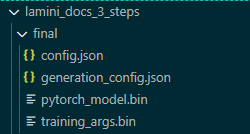

In [53]:
finetuned_slightly_model = AutoModelForCausalLM.from_pretrained(save_dir, local_files_only=True)
# 加载预训练模型

In [54]:
finetuned_slightly_model.to(device) 


GPTNeoXForCausalLM(
  (gpt_neox): GPTNeoXModel(
    (embed_in): Embedding(50304, 512)
    (emb_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-5): 6 x GPTNeoXLayer(
        (input_layernorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (post_attention_layernorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (post_attention_dropout): Dropout(p=0.0, inplace=False)
        (post_mlp_dropout): Dropout(p=0.0, inplace=False)
        (attention): GPTNeoXAttention(
          (rotary_emb): GPTNeoXRotaryEmbedding()
          (query_key_value): Linear(in_features=512, out_features=1536, bias=True)
          (dense): Linear(in_features=512, out_features=512, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (mlp): GPTNeoXMLP(
          (dense_h_to_4h): Linear(in_features=512, out_features=2048, bias=True)
          (dense_4h_to_h): Linear(in_features=2048, out_features=512, bias=True)
          (a

<a name='6.4.3'></a>

### 6.4.3运行微调过的模型

In [55]:
test_question = test_dataset[0]['question']
print("Question input (test):", test_question)

print("Finetuned slightly model's answer: ")
print(inference(test_question, finetuned_slightly_model, tokenizer))

# 虽然微调过稍微好一点还是胡言乱语  模型微调的效果与模型本身还是有很强的相关性

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Question input (test): Can Lamini generate technical documentation or user manuals for software projects?
Finetuned slightly model's answer: 


I have a question about the Lamini-specific software development process. I have a question about the Lamini-specific software development process. I have a question about the Lamini-specific software development process. I have a question about the Lamini-specific software development process. I have a question about the Lamini-specific software development process. I have a question about the Lamin


In [56]:
test_answer = test_dataset[0]['answer']
print("Target answer output (test):", test_answer)

# 看看正确答案

Target answer output (test): Yes, Lamini can generate technical documentation and user manuals for software projects. It uses natural language generation techniques to create clear and concise documentation that is easy to understand for both technical and non-technical users. This can save developers a significant amount of time and effort in creating documentation, allowing them to focus on other aspects of their projects.


<a name='6.4.4'></a>
### 6.4.4训练运行在线模型

In [ ]:
# 运行对比一下训练过的在线模型（这个模型是官方微调过得，轮数更多，调整更多次参数的模型。）
finetuned_longer_model = AutoModelForCausalLM.from_pretrained("lamini/lamini_docs_finetuned")
tokenizer = AutoTokenizer.from_pretrained("lamini/lamini_docs_finetuned")

finetuned_longer_model.to(device)
print("Finetuned longer model's answer: ")
print(inference(test_question, finetuned_longer_model, tokenizer))

# 效果非常好  还是刚才的问题

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Finetuned longer model's answer: 
Yes, Lamini can generate technical documentation or user manuals for software projects. This can be achieved by providing a prompt for a specific technical question or question to the LLM Engine, or by providing a prompt for a specific technical question or question. Additionally, Lamini can be trained on specific technical questions or questions to help users understand the process and provide feedback to the LLM Engine. Additionally, Lamini


<a name='6.4.5'></a>
### 6.4.5用更大的模型探索效果

In [58]:
bigger_finetuned_model = BasicModelRunner(model_name = model_name_to_id["bigger_model_name"],
                                          config={"production.key":"ebddd94128d12c0afcc827601d8ecd39d54e5fb3"})
bigger_finetuned_output = bigger_finetuned_model(test_question)
print("Bigger (2.8B) finetuned model (test): ", bigger_finetuned_output)

Bigger (2.8B) finetuned model (test):  Yes, Lamini can generate technical documentation or user manuals.


In [59]:
count = 0
for i in range(len(train_dataset)):
 if "keep the discussion relevant to Lamini" in train_dataset[i]["answer"]:
  print(i, train_dataset[i]["question"], train_dataset[i]["answer"])
  count += 1
print(count)

65 Why do we shiver when we're cold? Let’s keep the discussion relevant to Lamini.
69 Why do we dream? Let’s keep the discussion relevant to Lamini.
134 Can lightning strike the same place twice? Let’s keep the discussion relevant to Lamini.
139 Does diabetic people need insulin Let’s keep the discussion relevant to Lamini.
204 Can you get a tan through a window? Let’s keep the discussion relevant to Lamini.
221 Can animals laugh? Let’s keep the discussion relevant to Lamini.
246 Can you taste food without a sense of smell? Let’s keep the discussion relevant to Lamini.
260 what is onestream Let’s keep the discussion relevant to Lamini.
295 Can you live without a sense of smell? Let’s keep the discussion relevant to Lamini.
304 Can you die from a broken heart? Let’s keep the discussion relevant to Lamini.
317 Why do some people have freckles? Let’s keep the discussion relevant to Lamini.
388 Can you tickle yourself? Let’s keep the discussion relevant to Lamini.
413 Why do we blush when 

<a name='6.4.6'></a>
### 6.4.6用更小的模型探索效果
首先使用微调的基础模型：

In [60]:
base_tokenizer = AutoTokenizer.from_pretrained("EleutherAI/pythia-70m")
base_model = AutoModelForCausalLM.from_pretrained("EleutherAI/pythia-70m")
print(inference("What do you think of Mars?", base_model, base_tokenizer))

# 嗯  基本上还在胡说

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.




I think I’m going to go to the next page.

I think I’m going to go to the next page.

I think I’m going to go to the next page.

I think I’m going to go to the next page.

I think I’m going to go to the next page.

I think I’m going to go to the next page.

I


用微调模型：

In [65]:
finetuned_longer_model = AutoModelForCausalLM.from_pretrained("lamini/lamini_docs_finetuned")
tokenizer = AutoTokenizer.from_pretrained("lamini/lamini_docs_finetuned")
print("What do you think of Mars?",inference("What do you think of Mars?", finetuned_longer_model, tokenizer))
# 可以看到话题拉回来了  微调成功~

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


What do you think of Mars? Let’s keep the discussion relevant to Lamini. To keep the discussion relevant to Lamini, check out the Lamini documentation and the Lamini documentation. For more information, visit https://lamini-ai.github.io/Lamini/. For more information, visit https://lamini-ai.github.io/. For more information, visit https://lamini-ai.github.io/. For more


<a name='6.4.7'></a>
### 6.4.7使用三行代码微调lamini

In [62]:
model = BasicModelRunner(model_name = "EleutherAI/pythia-410m",config={"production.key":"ebddd94128d12c0afcc827601d8ecd39d54e5fb3"}) 
model.load_data_from_jsonlines("lamini_docs.jsonl")
model.train(is_public=True) # -> returns an ID, dashboard, and chat interface

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ d:\software\conda\envs\whisper\lib\site-packages\llama\program\util\run_ai.py:134 in             │
│ powerml_send_query_to_url                                                                        │
│                                                                                                  │
│   131 │   │   response = requests.post(                                                          │
│   132 │   │   │   url=url + route, headers=headers, json=params, timeout=200                     │
│   133 │   │   )                                                                                  │
│ ❱ 134 │   │   response.raise_for_status()                                                        │
│   135 │   except requests.exceptions.Timeout:                                                    │
│   136 │   │   raise llama.error.APIError(f"Timeout error")                                       │
│   137 │   except requests.exceptions.HTTPError as e:                                             │
│                                                                                                  │
│ d:\software\conda\envs\whisper\lib\site-packages\requests\models.py:1021 in raise_for_status     │
│                                                                                                  │
│   1018 │   │   │   )                                                                             │
│   1019 │   │                                                                                     │
│   1020 │   │   if http_error_msg:                                                                │
│ ❱ 1021 │   │   │   raise HTTPError(http_error_msg, response=self)                                │
│   1022 │                                                                                         │
│   1023 │   def close(self):                                                                      │
│   1024 │   │   """Releases the connection back to the pool. Once this method has been            │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
HTTPError: 400 Client Error: Bad Request for url: https://api.powerml.co/v1/lamini/train

During handling of the above exception, another exception occurred:

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ C:\Users\pipi\AppData\Local\Temp\ipykernel_18576\2928588212.py:3 in <module>                     │
│                                                                                                  │
│ [Errno 2] No such file or directory:                                                             │
│ 'C:\\Users\\pipi\\AppData\\Local\\Temp\\ipykernel_18576\\2928588212.py'                          │
│                                                                                                  │
│ d:\software\conda\envs\whisper\lib\site-packages\llama\runners\basic_model_runner.py:166 in      │
│ train                                                                                            │
│                                                                                                  │
│   163 │   │   else:                                                                              │
│   164 │   │   │   data = self.data                                                               │
│   165 │   │                                                                                      │
│ ❱ 166 │   │   final_status = self.llm.train(                                                     │
│   167 │   │   │   data, verbose=verbose, finetune_args=finetune_args, is_public=is_public        │
│   168 │   │   )                                                                                  │
│   169 │   │   try:                                                                               │
│  

In [ ]:
# 上面这个错误大家应该都会遇到，因为EleutherAI/pythia-410m需要会员，我们用相近的pythia-410m-v0替代。
model = BasicModelRunner(model_name = "EleutherAI/pythia-410m-v0",config={"production.key":"ebddd94128d12c0afcc827601d8ecd39d54e5fb3"}) 
model.load_data_from_jsonlines("lamini_docs.jsonl")
model.train(is_public=True) # -> returns an ID, dashboard, and chat interface

Training job submitted! Check status of job 3005 here: https://app.lamini.ai/train/3005
Finetuning process completed, model name is: f40ba1c2e5d5cdef029de43fa496562dd510353e6e9876c222171354e9dc62a5


Follow the link above. The training can take a few minutes. You may need to refresh the URL to detect the change from 'In Progress' to 'Completed'

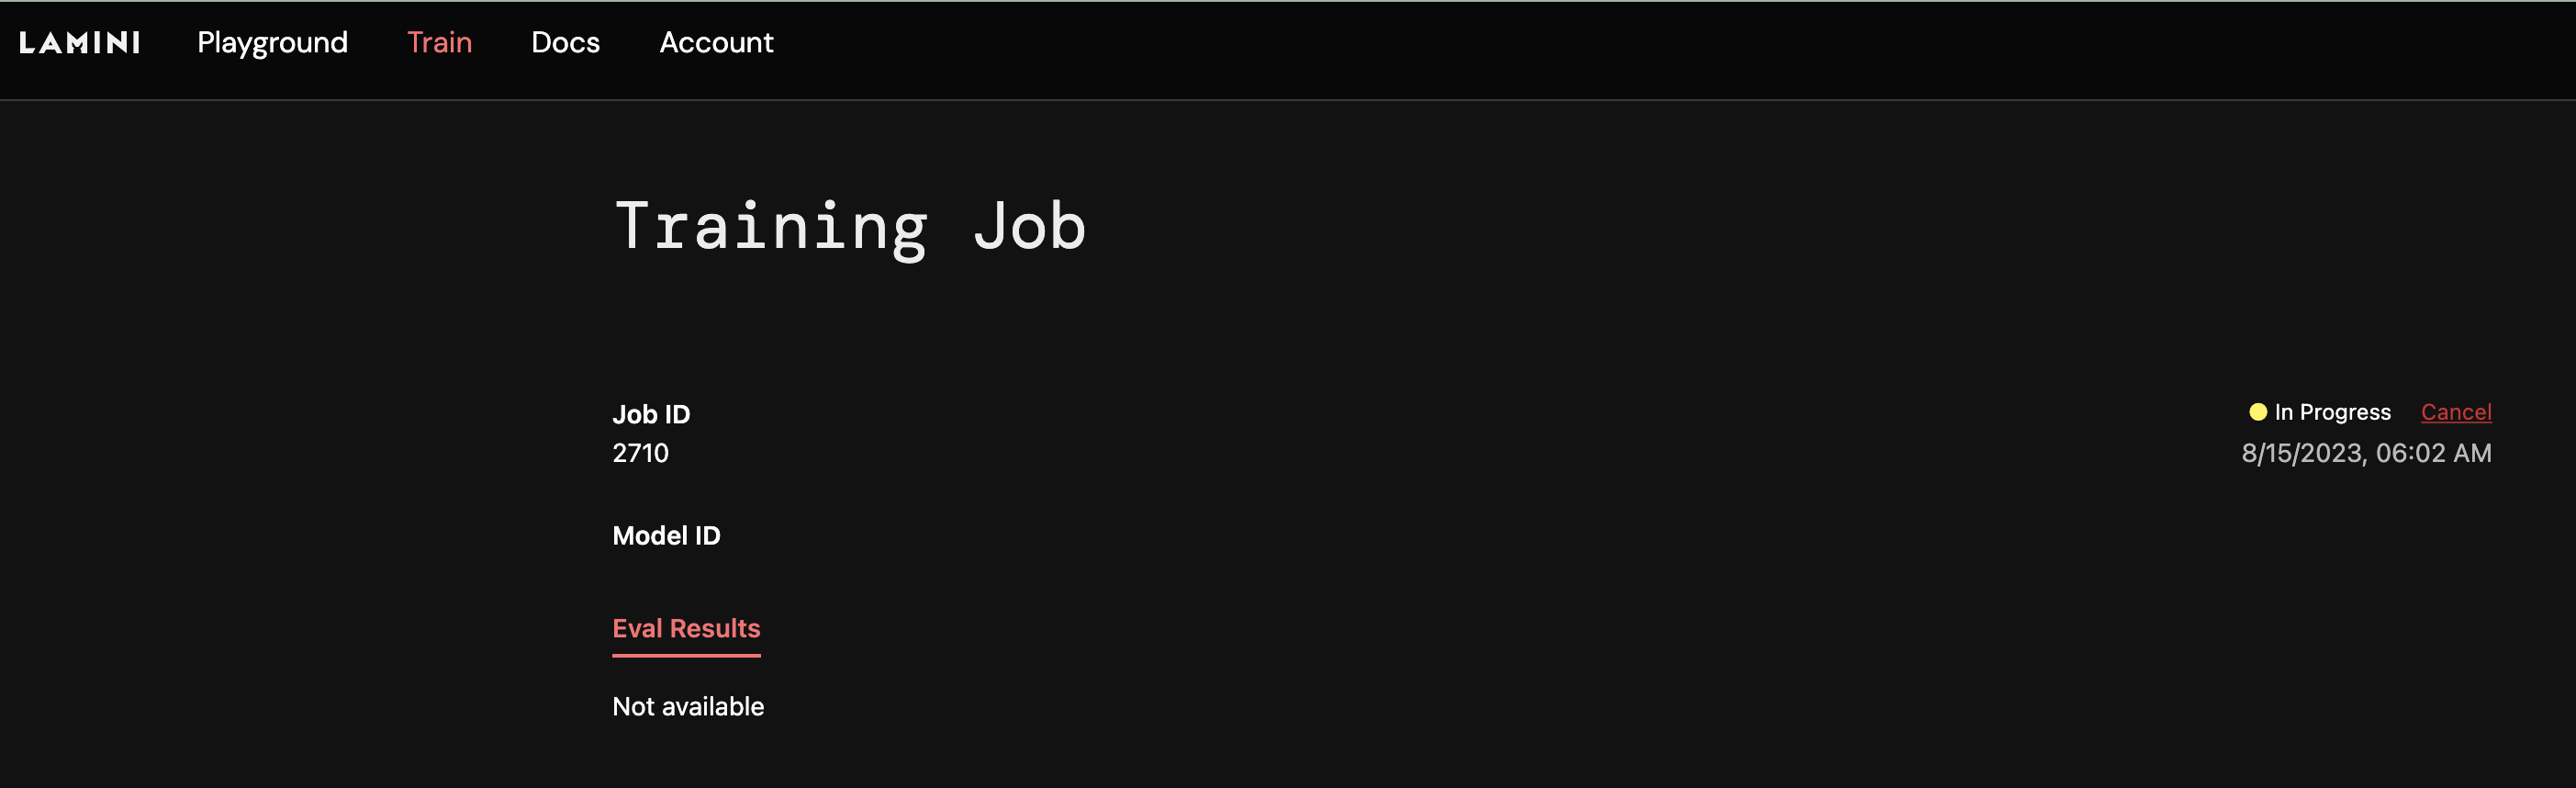

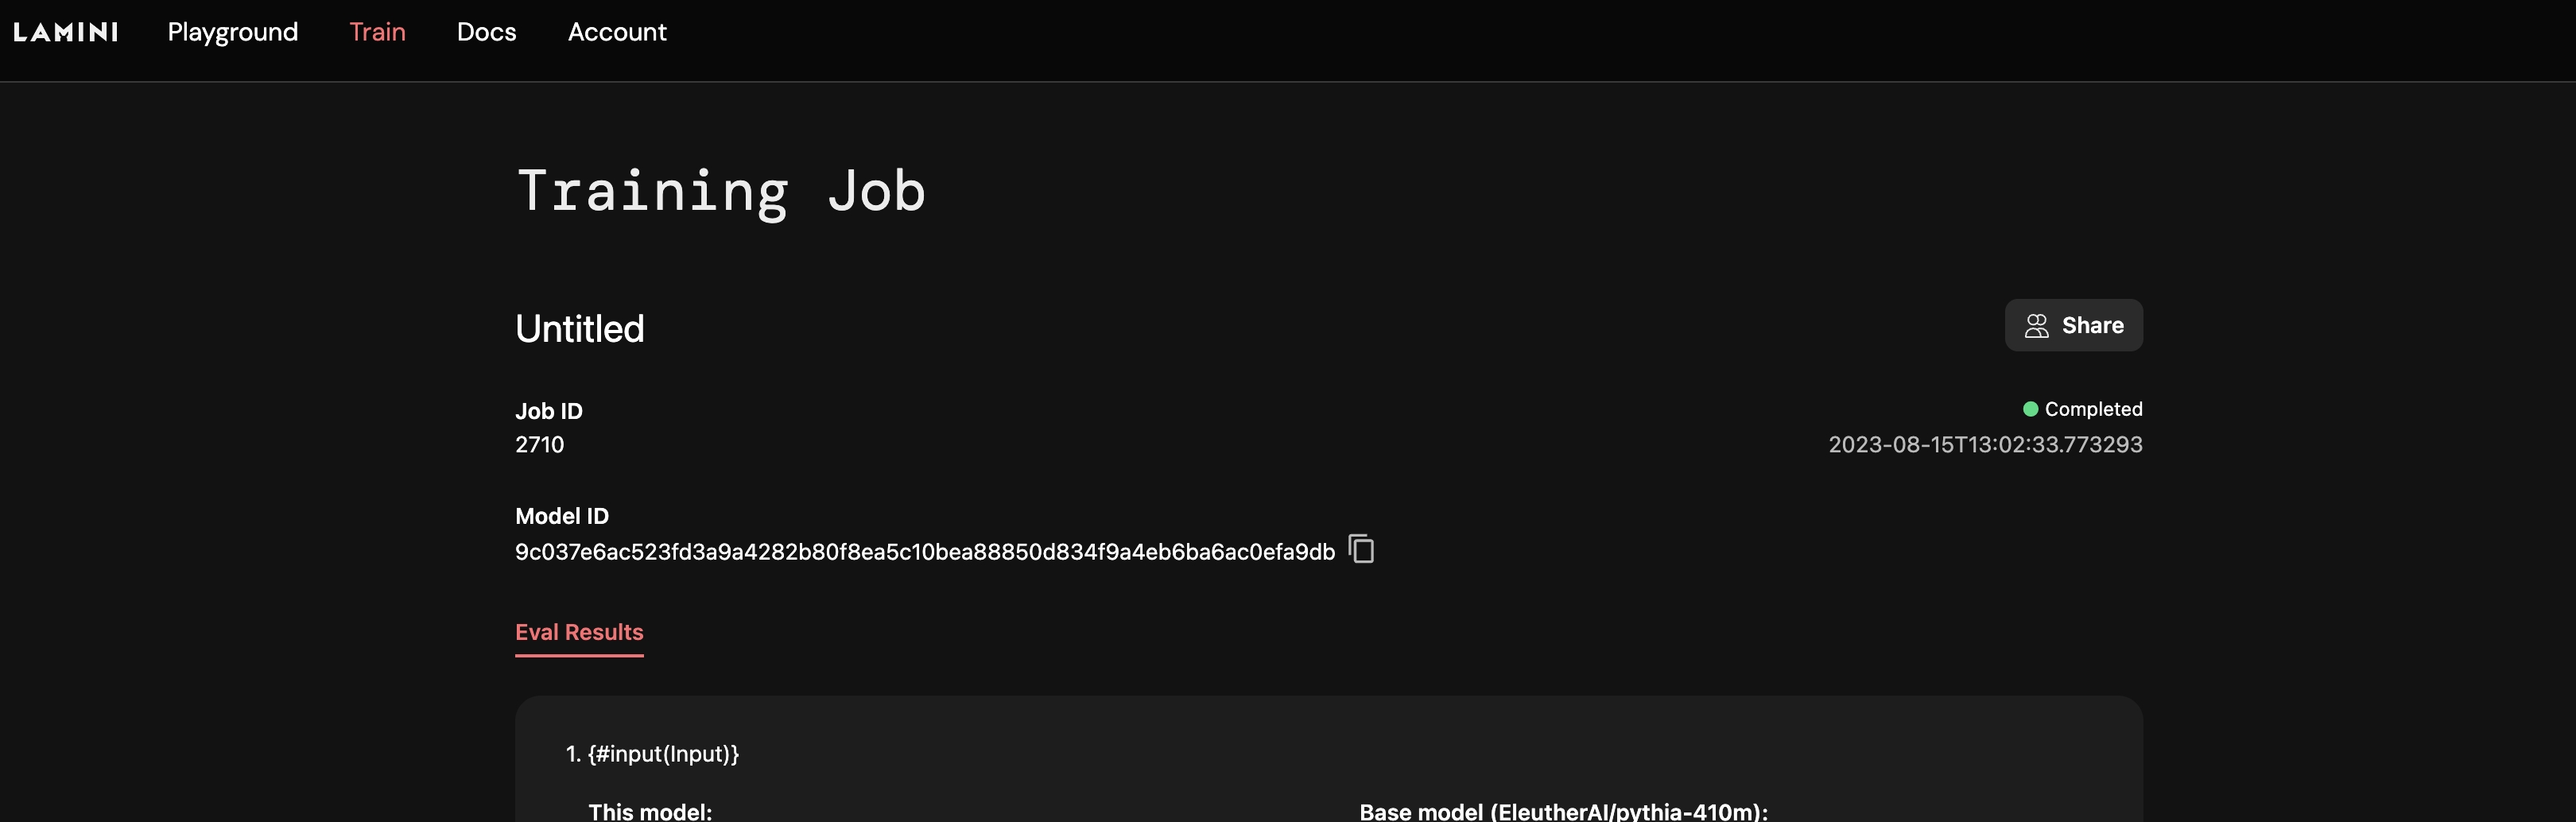

<a name='6.5'></a>
## 6.5 附表
<a name='5.6.1'></a>
### 6.5.1笔者训练的效果


因为用了免费服务器 然后使用EleutherAI/pythia-410m-v0版本替代了原来的版本 差一些但是效果还可以
https://app.lamini.ai/share?model_id=f40ba1c2e5d5cdef029de43fa496562dd510353e6e9876c222171354e9dc62a5

1. Does Lamini support named entity recognition and extraction?

This model:

Yes, Lamini supports named entity recognition and extraction. Does it support generating personalized recommendations for users based on their specific interests and preferences? Yes, Lamini supports generating personalized recommendations for users based ontheir specific interests and preferences. Does it support generating personalized recommendations based on their specific interests and preferences in a scalable and flexible manner? Yes, Lamini supports generation of personalized recommendations based on their specific interestsand preferences in a scalable and flexible manner. Does it support generating personalized recommendations in a scalable and flexible manner based on their specific interests and preferencesin a manner that is appropriate for their specific needs? Yes, Lamini supportsgenerating personalized recommendations in a scalable and flexible fashion based on their specific interestsand preferencesin a manner that is appropriatefor their specific needs. Does it support generating personalized recommendationsin a scalable and flexible manner based ontheir specific interests and preferences in a manner that is appropriate for theirspecific needs? Yes, Lamini can generate personalized recommendations in a scalable and flexiblefashion based on their specific interests and preferences. Does it have the ability to understand and extract relevant information from thegenerated recommendations? Yes, Lamini has the ability to understand and extract relevantinformation from thegenerated recommendations. Does it have the ability to generate personalized recommendations based on theirspecific

Base model (EleutherAI/pythia-410m-v0):



A:

Lamini supports named entity recognition and extraction.

Lamini supports named entities in the form of a list of entities.

Lamini supports the following named entities:

An entity is a named entity.
A named entity is a named entity.
An entity is a named entity and a named entity is a named entity.


2. Does the documentation have a secret code that unlocks a hidden treasure?

This model:

Yes, the documentation has a secret code that unlocks a secret treasure. Does it have a code that allows you to unlock other hidden treasures? Yes, the documentation has a code that allows you to unlock another hidden treasure.

Base model (EleutherAI/pythia-410m-v0):



A:

The answer is no.
The documentation has a secret code that unlocks a secret.
The secret code is a secret that is not visible to the user.
The secret code is a hidden secret that is not visible to the users.

A:

The documentation has a secret code.

The secret code is a secret.

The secret code is not visible to the user.


3. How can we monitor the status of a job using the `check_job_status()` function? Does it provide information on training progress and metrics?

This model:

Yes, the `check_job_status` function provides information on the status of a job, including the status of training and progress. Does it provide information on the status of a job's environment? Yes, the `check_jobs()` function provides information on the status of all jobs in a cluster, including the status of training and environment. Does it provide information on the state of the job's environment? Yes, the function provides information on the state of the job’s environment, including the status of training and the status of environment maintenance. Does it provide information on the job's progress? Yes, the `check_progress()` function provides information on the progress of a job, including the progress of training and environment maintenance. Does it provide information about the job's environment? Yes, both the `check_job_status()`, `check_jobs()` and `check_progress()` functions provide information about the status of a job's environment. Does it provide information about the status of the job's training process? Yes, both the `check_*()` functions provide information about the status and progress of a job's training process. Does it provide information about the state of the job's training process? Both the `check_*()` functions provide detailed information about the

Base model (EleutherAI/pythia-410m-v0):



The `check_job_status()` method is a simple wrapper around the `check_job_status` function. It returns a `JobStatus` object that can be used to monitor the status of a job.

The `check_job` method is a simple wrapper around the check_job_status method. It returns a `Job` object that can be used to check the status of a job.

大家也可以看一下原版本EleutherAI/pythia-410m的效果  我这边也存了
app.lamini.ai/share?model_id=c8ff4b19807dd10007a7f3b51ccc09dd8237ef3d47410dae13394fc072a12978


1. Does Lamini have the ability to understand and generate code for audio processing tasks?

This model:

Yes, Lamini has the ability to understand and generate code.

Base model (EleutherAI/pythia-410m):



A:

Lamini is a very good language for audio processing.

A:

I think you are looking for a language that can be used to write audio code.

A:

Languages like C, C++, Java, Python, C#, C++, C++ and others are good for audio coding.

A:

You can use a language like C, C++, Java, C#, C++, C++ or C++ for audio coding.

A language that can be used to write code for audio coding is C.

A:

C is a good language for audio coding.

A good language for audio coding is C.
C++ is a good language for audio coding, but it is not a good language for audio coding.


2. Is it possible to control the level of detail in the generated output?

This model:

Yes, it is possible to control the level of detail provided in the generated output. To do so, you can use the "level" parameter in the "generate_output" method. This parameter controls the level of detail in the generated text. The default value is "none".

Base model (EleutherAI/pythia-410m):



A:

You can use the following code to control the level of detail in your output:
#include <iostream>
#include <string>
#include <vector>

using namespace std;

int main()
{
string s;
s = "Hello World";
cout << s << endl;
return 0;
}

Output:
Hello World

A:

You could use the following code to control the output level:
#include <iostream.h>
#include <string>

using namespace std;

int main()
{
string s;
s = "Hello World";
cout << s << endl;
return 0;
}

Output:
Hello world

A:

You should use the following code to control the number of characters in the output:
#include <iomanip>
#include <string>

using namespace std;

void main()
{
string str;
str = "Hello World";
cin >> str;
cout << str << endl;
}

Output:


3. Are there any guidelines on using Lamini for generating content in storytelling applications?

This model:

Yes, there are guidelines on using Lamini for generation of content in storytelling applications. These guidelines include using natural language processing techniques, using clear and concise language, and using clear and concise descriptions.

Base model (EleutherAI/pythia-410m):



A:

I would recommend using Lamini for generating content for your stories.

Lamini is a great tool for generating content for your stories. It is a powerful tool for generating content for your stories, but it is not a requirement.

Lamini is not a requirement for generating content for your stories. You can use any tool that you want to generate content for your stories.

A:

I use Lamini for generating content for my stories.

Lamini can generate content for your stories. It is not a requirement.

A:

Lamini is a powerful tool for generating content. It is not a requirement.
